# Active learning

In [26]:
import logging
logging.captureWarnings(True)

import deepsensor.torch
from deepsensor.data import DataProcessor, TaskLoader
from deepsensor.model import ConvNP
from deepsensor.active_learning import GreedyAlgorithm
from deepsensor.data import DataProcessor, TaskLoader, construct_circ_time_ds
from deepsensor.data.sources import get_era5_reanalysis_data, get_earthenv_auxiliary_data, get_gldas_land_mask

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

In [27]:
# Training/data config
data_range = ("2010-01-01", "2019-12-31")
train_range = ("2010-01-01", "2018-12-31")
val_range = ("2019-01-01", "2019-12-31")
date_subsample_factor = 2
extent = "usa"
station_var_IDs = ["TAVG"]
era5_var_IDs = ["2m_temperature"]
lowres_auxiliary_var_IDs = ["elevation"]
cache_dir = "../../.datacache"
deepsensor_folder = "../deepsensor_config/"
model_folder = "../model/"
verbose_download = True

In [28]:
era5_raw_ds = get_era5_reanalysis_data(era5_var_IDs, extent, date_range=data_range, cache=True, cache_dir=cache_dir, verbose=verbose_download, num_processes=8)
lowres_aux_raw_ds = get_earthenv_auxiliary_data(lowres_auxiliary_var_IDs, extent, "100KM", cache=True, cache_dir=cache_dir, verbose=verbose_download)
land_mask_raw_ds = get_gldas_land_mask(extent, cache=True, cache_dir=cache_dir, verbose=verbose_download)

data_processor = DataProcessor(x1_name="lat", x2_name="lon")
era5_ds = data_processor(era5_raw_ds)
lowres_aux_ds, land_mask_ds = data_processor([lowres_aux_raw_ds, land_mask_raw_ds], method="min_max")

dates = pd.date_range(era5_ds.time.values.min(), era5_ds.time.values.max(), freq="D")
doy_ds = construct_circ_time_ds(dates, freq="D")
lowres_aux_ds["cos_D"] = doy_ds["cos_D"]
lowres_aux_ds["sin_D"] = doy_ds["sin_D"]

100%|██████████████████████████████████████████████████████████████████| 120/120 [00:02<00:00, 53.73it/s]


1.41 GB loaded in 3.05 s


In [29]:
task_loader = TaskLoader(
    context=[era5_ds, land_mask_ds, lowres_aux_ds],
    target=era5_ds,
)
task_loader.load_dask()
print(task_loader)

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('2m_temperature',), ('GLDAS_mask',), ('elevation', 'cos_D', 'sin_D'))
Target variable IDs: (('2m_temperature',),)


In [30]:
# set_gpu_default_device()

In [31]:
# Load model
model = ConvNP(data_processor, task_loader, deepsensor_folder)

## `GreedyAlgorithm`

blah

In [32]:
from deepsensor.active_learning import GreedyAlgorithm

alg = GreedyAlgorithm(
    model,
    X_s=era5_raw_ds,
    X_t=era5_raw_ds,
    X_s_mask=land_mask_raw_ds,
    X_t_mask=land_mask_raw_ds,
    context_set_idx=0,
    target_set_idx=0,
    N_new_context=10,
    progress_bar=True,
)

## `AcquisitionFunction`

blah

In [33]:
from deepsensor.active_learning.acquisition_fns import Stddev

acquisition_fn = Stddev(model, context_set_idx=0, target_set_idx=0)

## Running the algorithm

Blah

In [34]:
val_dates = pd.date_range(val_range[0], val_range[1])[::date_subsample_factor]
placement_dates = val_dates[0:1]
placement_tasks = task_loader(placement_dates, context_sampling=[100, "all", "all"], seed_override=0)

X_new_df, acquisition_fn_ds = alg(acquisition_fn, placement_tasks)

100%|████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.31it/s]


In [35]:
X_new_df

,x1,x2
iteration,,
0,64.50,-119.75
1,70.00,-159.50
2,73.25,-122.25
3,67.50,-135.75
4,44.00,-106.75
5,36.25,-110.00
6,24.75,-100.00
7,48.00,-90.75
8,62.50,-113.25


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


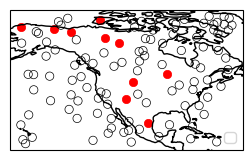

In [36]:
fig = deepsensor.plot.placements(placement_tasks[0], X_new_df, data_processor,
                                 crs=ccrs.PlateCarree())

Averaging acquisition function over dims for plotting: ['time']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


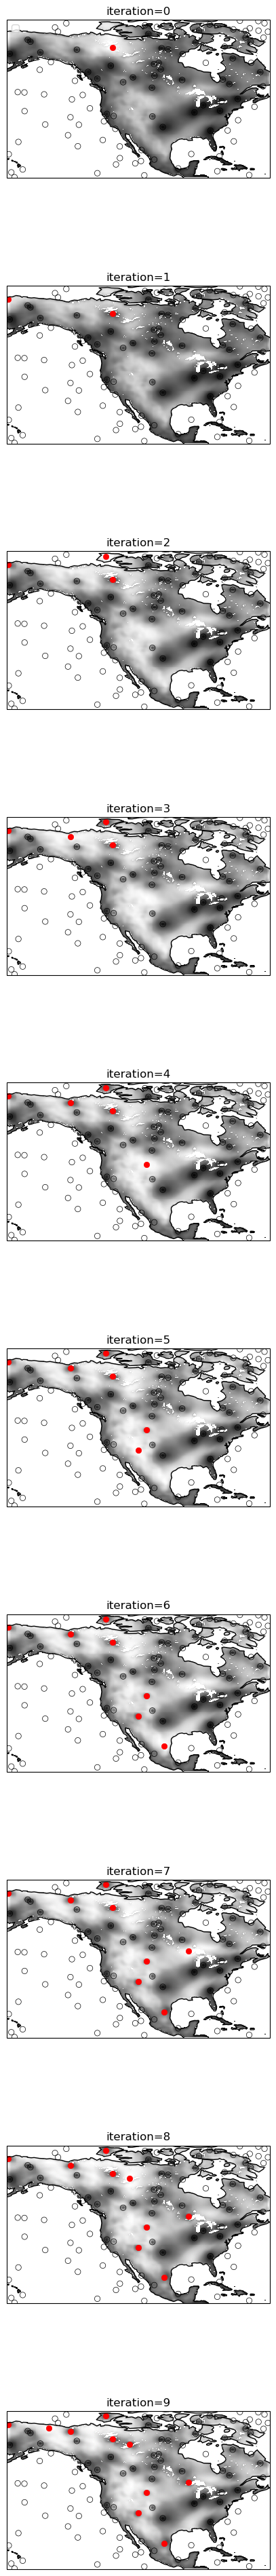

In [37]:
fig = deepsensor.plot.acquisition_fn(placement_tasks[0], acquisition_fn_ds, X_new_df,
                                     data_processor, crs=ccrs.PlateCarree(), add_colorbar=False,
                                     max_ncol=1, figsize=5)